# Análise Gráfica das Palavras Hidroxicloroquina e Cloroquina
#### (Daniel)

## Implementando Funções

In [141]:
import nltk
import re
import pandas as pd
from IPython.display import clear_output
from collections import defaultdict
from string import punctuation
import numpy as np
#stopwords em portugues
from nltk.corpus import stopwords
stopwords = set(stopwords.words('portuguese') + list(punctuation) + ['“','”'])

#funçao pra limpeza de texto
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)

In [218]:
#funçao pra leitura de dados e criaçao de dataframe
def json_to_dataframe(nome_json, colunas, chunk):
    dados = pd.read_json(nome_json, convert_dates = False, lines = True, chunksize = chunk)    
    
    for df_tweets_retweets in dados:
        yield df_tweets_retweets[colunas]

In [4]:
#funçao pra leitura de dados e criaçao de dataframe
def json_to_dataframe_retweets(nome_json, colunas, chunk):
    dados = pd.read_json(nome_json, convert_dates = False, lines = True, chunksize = chunk)    
    
    for df_tweets_retweets in dados:
        yield df_tweets_retweets.dropna(subset=['retweeted_status'])[colunas]

In [5]:
#funçao pra limpar texto e retirar stopwords
def tokenizar_texto(texto_tweet):
    texto_tokenizado = tweet_tokenizer.tokenize(texto_tweet)

    if texto_tokenizado[0] == "rt" and texto_tokenizado[1] == ":":
        del texto_tokenizado[0]
    
    palavras_sem_stopwords = [palavra for palavra in texto_tokenizado if palavra not in stopwords] 
    return palavras_sem_stopwords

In [8]:
#funçao pra criar dicionario com a data e quantidade das palavras chaves
def contagem_pchaves_data(pchaves_lista, gerador,destino):
    
    dict_datas_pchaves = defaultdict(dict)            
    
    for dataframe in gerador:        
        for linha in dataframe.values:            
            texto_tweet = list(tokenizar_texto(linha[0]))

            for palavra in texto_tweet:                
                if palavra in pchaves_lista:
                    data = linha[1]['$date'][:10]
                    if data not in dict_datas_pchaves or palavra not in dict_datas_pchaves[data]:
                        dict_datas_pchaves[data][palavra] = 0
                    dict_datas_pchaves[data][palavra] += 1 
            clear_output()
            
    escrever_arq_csv(dict_datas_pchaves,destino)

In [230]:
#funcao que conta a quantidade e proporção de retweets nos tweets
def prop_retweets(arquivo):
    retweets=0
    tweets=0
    gerador = json_to_dataframe(arquivo,['retweeted_status'],2000)
    for dataframe in gerador:
        for linha in dataframe.values:
            if type(linha[0])==dict:
                retweets+=1
            tweets+=1
    return retweets,retweets/tweets

In [204]:
#funcao que conta a quantidade e proporção de DIAS nos tweets
def prop_dias(arquivo):
    datas = {}
    tweets = 0
    gerador = json_to_dataframe(arquivo,['created_at'],2000)
    for dataframe in gerador:
        for linha in dataframe.values:
            data = linha[0]['$date'].split('T')[0]
            if data not in datas:#[:2] == 'RT':
                datas[data] =0
            datas[data] += 1
            tweets+=1
    return datas,tweets

In [6]:
#funçao pra escrever os resultados no arquivo csv
def escrever_arq_csv(dict_datas_pchaves,destino):
    with open(destino, 'w', encoding="utf-8") as f:
        f.write("Data;Palavra;Ocorrencias\n")
    
        for key in dict_datas_pchaves.keys():
            for palavra in dict_datas_pchaves[key].keys():
                f.write("%s;%s;%s\n"%(key, palavra, dict_datas_pchaves[key][palavra]))
            
    print('A contagem de palavras chaves por data foi salva com sucesso no arquivo')

In [235]:
def escrever_datas_arq(datas,destino):
    with open(destino, 'w', encoding="utf-8") as f:
        f.write("Data;Ocorrencias\n")
        for data in datas:
            f.write("%s;%s\n"%(data,datas[data]))

## Execução

### Gerar csv's com os dados das palavras em tweets e retweets

In [10]:
#execuçao do codigo para tweets
gerador = json_to_dataframe('tweets_222_23abr2020.json',["text","created_at"], 30)

contagem_pchaves_data(['hidroxicloroquina', 'cloroquina'], gerador,'cont_hidro_cloro_data.csv')

A contagem de palavras chaves por data foi salva com sucesso no arquivo


In [105]:
#execuçao do codigo para retweets
gerador = json_to_dataframe_retweets('tweets_222_23abr2020.json',["text","created_at"], 30)

contagem_pchaves_data(['hidroxicloroquina', 'cloroquina'], gerador,'cont_hidro_cloro_data_retweets.csv')

A contagem de palavras chaves por data foi salva com sucesso no arquivo


### Calcular proporções de retweets e datas no arquivo analisado

In [231]:
#execução prop_retweets
rtts,prop = prop_retweets("tweets_222_23abr2020.json")
rtts,prop

(4457829, 0.6378437878099341)

In [208]:
#execução prop_retweets
datas,tweets = prop_dias("tweets_222_23abr2020.json")
datas,tweets

({'2020-04-11': 260502,
  '2020-04-12': 1316303,
  '2020-04-13': 1157405,
  '2020-04-14': 1361567,
  '2020-04-15': 1396492,
  '2020-04-16': 383271,
  '2020-04-22': 832755,
  '2020-04-23': 280609},
 6988904)

### Escevendo ocoências das datas no arquivo

In [236]:
escrever_datas_arq(datas,'datas_23abr.csv')

### Ler csv's e gerar DataFrame agregado com todos os valores para análise

In [243]:
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
cont_tweets = pd.read_csv('cont_hidro_cloro_data.csv',sep=';') # Ler dados coletados dos tweets
cont_tweets = cont_tweets.sort_values(by='Data').set_index(['Data','Palavra']) # Indexação para garantir correta associação dos DataFrames
cont_retweets = pd.read_csv('cont_hidro_cloro_data_retweets.csv',sep=';') # ler dados coletados dos retweets
cont_retweets = cont_retweets.sort_values(by='Data').set_index(['Data','Palavra']) # Indexação para garantir correta associação dos DataFrames
cont_tweets # Visualizar DataFrame com os valores de tweets

Ocorrencias
Data       Palavra                       
2020-04-11 cloroquina               11520
           hidroxicloroquina         3486
2020-04-12 cloroquina               65272
           hidroxicloroquina        14723
2020-04-13 cloroquina               45901
           hidroxicloroquina        13897
2020-04-14 cloroquina               64621
           hidroxicloroquina        24931
2020-04-15 hidroxicloroquina        16042
           cloroquina               62765
2020-04-16 cloroquina               24653
           hidroxicloroquina         4933
2020-04-22 hidroxicloroquina        10195
           cloroquina               14953
2020-04-23 cloroquina                8376
           hidroxicloroquina         5523

In [244]:
cont_retweets

Ocorrencias
Data       Palavra                       
2020-04-11 cloroquina               10036
           hidroxicloroquina         3208
2020-04-12 cloroquina               57391
           hidroxicloroquina        13042
2020-04-13 cloroquina               38490
           hidroxicloroquina        12486
2020-04-14 cloroquina               52449
           hidroxicloroquina        22117
2020-04-15 cloroquina               51051
           hidroxicloroquina        14051
2020-04-16 cloroquina               21995
           hidroxicloroquina         4604
2020-04-22 hidroxicloroquina         9058
           cloroquina               11937
2020-04-23 cloroquina                7157
           hidroxicloroquina         5009

In [248]:
cont = cont_tweets.copy()
cont["Retweets"] = cont_retweets.Ocorrencias
cont.rename(columns={'Ocorrencias':'Tweets'},inplace=True)
cont = cont.reset_index()
cont # Visualizar DataFrame gerado com os valores de retweets e tweets

,Data,Palavra,Tweets,Retweets
0,2020-04-11,cloroquina,11520,10036
1,2020-04-11,hidroxicloroquina,3486,3208
2,2020-04-12,cloroquina,65272,57391
3,2020-04-12,hidroxicloroquina,14723,13042
4,2020-04-13,cloroquina,45901,38490
5,2020-04-13,hidroxicloroquina,13897,12486
6,2020-04-14,cloroquina,64621,52449
7,2020-04-14,hidroxicloroquina,24931,22117
8,2020-04-15,hidroxicloroquina,16042,14051
9,2020-04-15,cloroquina,62765,51051


### Reestruturação dos Dados para geração dos Gráficos

In [249]:
index = []
for i in cont.Palavra[:2].values:
    i_t = i+'-Tweet'
    i_r = i+'-Retweet'
    index.append(i_t)
    index.append(i_r)
index

['cloroquina-Tweet',
 'cloroquina-Retweet',
 'hidroxicloroquina-Tweet',
 'hidroxicloroquina-Retweet']

In [250]:
new = pd.DataFrame(index=index,columns=cont.Data[::2].values)
df = cont.set_index(['Data','Palavra']).T.copy()
df[('2020-04-11', 'cloroquina')]

Tweets      11520
Retweets    10036
Name: (2020-04-11, cloroquina), dtype: int64

In [251]:
for data_palavra in df.columns:
    new[data_palavra[0]][data_palavra[1]+'-Tweet'] = df[data_palavra]['Tweets']
    new[data_palavra[0]][data_palavra[1]+'-Retweet'] = df[data_palavra]['Retweets']    
new # Visualização dos Dados após Reestruturação

,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-22,2020-04-23
cloroquina-Tweet,11520,65272,45901,64621,62765,24653,14953,8376
cloroquina-Retweet,10036,57391,38490,52449,51051,21995,11937,7157
hidroxicloroquina-Tweet,3486,14723,13897,24931,16042,4933,10195,5523
hidroxicloroquina-Retweet,3208,13042,12486,22117,14051,4604,9058,5009


## Gráficos

### Gráfico de pizza da proporção de retweets em tweets

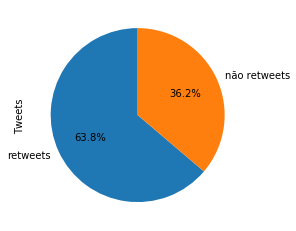

In [232]:
proporcao = pd.Series({'retweets':rtts,'não retweets':rtts/prop-rtts},name='Tweets')
proporcao.plot(kind='pie',autopct='%1.1f%%',startangle=90,legend=False)#,xticks=[(str(prop*100)+'%'),(str((1-prop)*100)+'%')]

### Gráfico de pizza da proporção de datas dos tweets no arquivo

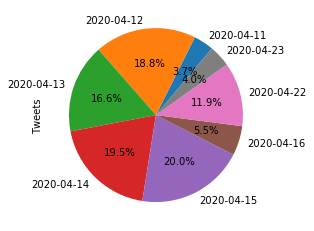

In [239]:
prop_dts = pd.Series(datas,name='Tweets')
prop_dts.plot(kind='pie',autopct='%1.1f%%',startangle=50,legend=False,)

### Gráfico de linhas da ocorrência das palavras no tempo decorrido no arquivo

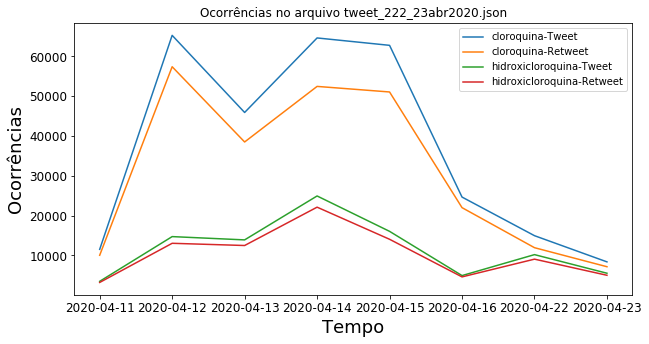

In [252]:
grafico_barras = new.T.plot(kind='line', title ="Ocorrências no arquivo tweet_222_23abr2020.json",figsize=(10,5),legend=True, fontsize=12)
grafico_barras.set_xlabel("Tempo",fontsize=18)
grafico_barras.set_ylabel("Ocorrências",fontsize=18)

plt.show()


### Gráfico de barras da ocorrência das palavras no tempo decorrido no arquivo

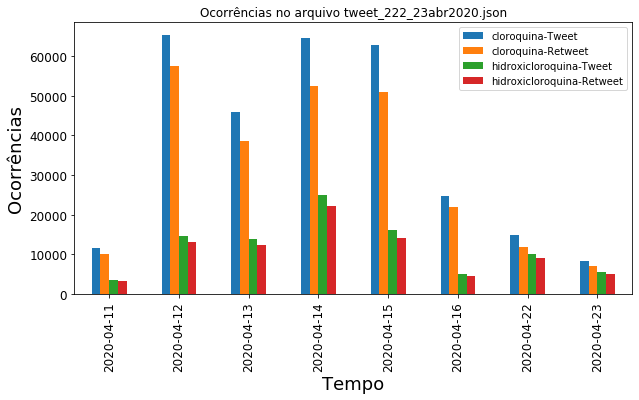

In [253]:
grafico_barras = new.T.plot( kind='bar', title ="Ocorrências no arquivo tweet_222_23abr2020.json",figsize=(10,5),legend=True, fontsize=12)
grafico_barras.set_xlabel("Tempo",fontsize=18)
grafico_barras.set_ylabel("Ocorrências",fontsize=18)

plt.show()
